In [15]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
import time
import random

In [16]:
def population_SSA(G0,G1,m0,p0,t0,phase0,age0,Tmax,Ncycle,Tcycle,son,soff,rho,lam,dm):

     """
    SSA to simulate population observation for Models IV in the paper:
    "Exact solution of a three-stage model of stochastic gene expression model including cell-cycle dynamics" 

    Input: 
        t0            - initial time at which we start to measure the cell (float+, can be array/list)
        G0          - gene in active state  (0 or 1,  can be array/list)
        G1          - gene in inactive state (0 or 1, can be array/list)
        m0          - initial mRNA level of cell (integer, can be array/list)
        p0          - initial protein level of cell (integer, can be array/list)
        age0        - initial age of cell within phase (float+, can be array/list)
        phase0      - initial phase of cell (0 or 1, can be array/list)
        Tmax        - final time of observation (float+)
        Ncycle      - cell-cycle variability parameter, number of stages in Erlang model (float+)

   
    Output:
        P           - array containing:
                        first row the measurement times
                        second row the gene in active state
                        third row the gene in inactive state
                        fourth row the mRNA level
                        fifth row the protein level
                        sixth row the cell age within current phase at measurement
                        seventh row the cell phase at measurement
    """

    t0 = np.asarray(t0).flatten(); 
    G0 = np.asarray(G0).flatten();
    G1 = np.asarray(G1).flatten();
    m0 = np.asarray(m0).flatten();
    p0 = np.asarray(p0).flatten();
    age0 = np.asarray(age0).flatten();
    phase0 = np.asarray(phase0).flatten(); 
    

    # Estimate from population growth how big Q should be if we start from a single cell
    #qx_max = int((np.exp(Ncycle*(2**(1./Ncycle)-1)))**(Tmax))
    qx_max = 100
    # Account for possibility of starting from multiple cells
    qx_max *= np.size(m0)   
    Q = np.zeros((7,qx_max))
    
    # Pre-allocate array to save the protein levels at final time
    P = np.zeros((7,qx_max))
    px = 0
    
    # Read initial values supplied and write to the queue
    for qx in range(np.size(m0)):
        # Initial absolute time for the cell (relative to Tmax measurement time)
        t = t0[qx]
        # Initial protein level
        g0=G0[qx]
        g1=G1[qx]
        mRNA = m0[qx]
        protein=p0[qx]
        # Initial age of the cell within the phase
        age = age0[qx]
        # Initial phase of the cell, where
        phase = phase0[qx]
        Q[:,qx]= np.array([t,g0,g1,mRNA,protein,age,phase])
    qx += 1
    
    # Iterate until we have finished all the cells in the queue
    while px < qx:

        # Load the next element from the queue to simulate from
        t = Q[0,px]
        g0=Q[1,px]
        g1=Q[2,px]
        mRNA=Q[3,px]
        protein = Q[4,px]
        age = Q[5,px]
        phase = Q[6,px]
        # Time until the next cell phase/division event
        # Need to account for possiblity of age > 0, i.e. we need to generate from the truncated
        # distribution given that the next cell progression event > current age
        # Print some progression stats, roughly at every 10% of number of cells we expect to simulate
        if px % int(qx_max/10) == 0:
            print("Completed %d cells, queue length %d, expected final queue length %d" %(px,qx,qx_max))
            
            
        k=Ncycle/Tcycle
        tnext=-np.log(np.random.rand())/k
     
        # Account for degenerate (one-phase) case
        if np.isnan(tnext):
            tnext = 0 
    
        while t < Tmax:
        
            prop= [g0*soff,g1*son,g0*rho,mRNA*lam,mRNA*dm]
            prop_total=sum(prop)
            rand_2=np.random.rand()
            rand_1=np.random.rand()
            dt = - np.log(rand_2)/prop_total
            # Check whether first to fire reaction or change cell phase
            # 1) Biochemical reactions
            if tnext > dt:
                # Check if we don't go over final time
                if t + dt < Tmax:
                    #on->off
                    if rand_1*prop_total < sum(prop[0:1]):
                        g1+=1
                        g0-=1
                    # off->on
                    elif sum(prop[0:1])<=rand_1*prop_total < sum(prop[0:2]):
                        g1-=1
                        g0+=1
                    # G->G+M
                    elif sum(prop[0:2])<=rand_1*prop_total<sum(prop[0:3]):
                        mRNA+=1
                    #M->M+P
                    elif sum(prop[0:3])<=rand_1*prop_total<sum(prop[0:4]):
                        protein+=1
                    #M->0
                    else:
                        mRNA -= 1
                    tnext -= dt
                    # Update the simulation time
                    t += dt 
                    # Update cell age
                    age += dt
                #The reaction time has exceeded the maximum time
                else:
                    # Update the cell age
                    age += (Tmax-t)
                    t += (Tmax-t)
                    # Final time reached without further reaction, save state
                    P[0,px] = t
                    P[1,px] =g0
                    P[2,px] =g1
                    P[3,px] = mRNA
                    P[4,px] = protein
                    P[5,px] = age
                    P[6,px] = phase
                    px += 1
                    # Final time reached, break to end simulation of this cell
                    break
            # 2) Phase progression
            else:
                dt = tnext
                if t + dt < Tmax:               
                    # Update the simulation time
                    t += dt   
                    # Update cell age                        
                    age += dt
                    # Update the phase and time to next phase change
                    if phase != Ncycle-1:
                        # Update cell age                                
                        age = 0                                
                        # Progress to next phase
                        phase += 1
                        # Generate time till next phase change

                    else:
                        # Apply the binomial partitioning
                        #if protein > 0:
                        protein_other = np.random.binomial(protein, 0.5)
                        mRNA_other = np.random.binomial(mRNA, 0.5)
                        # Update the queue with new cell at time t with contents protein_other 
                        # and age=0 and phase=0
                        Q[:,qx] = np.array([t,g0,g1,mRNA_other,protein_other,0,0])
                        qx += 1
                        # Check if queue still long enough, otherwise extend by doubling size
                        if qx >= qx_max:
                            Q = np.concatenate((Q,np.zeros(np.shape(Q))),axis=1)   
                            P = np.concatenate((P,np.zeros(np.shape(P))),axis=1)
                            qx_max *= 2
                        # Update the current cell contents, 
                        # remove the binomial partitioning part which is in the queue
                        protein -= protein_other
                        mRNA-=mRNA_other
                        # Progress to pre replication phase
                        # Update cell age                                
                        age = 0                                
                        # Progress to first phase
                        phase = 0           
                        # Generate time till next phase change

                    # Account for degenerate (one-phase) case
                    if np.isnan(tnext):
                        tnext = 0
                    # Next reaction time
                    tnext=-np.log(np.random.rand())/k
                        
                else:
                    # Update the cell age
                    age += (Tmax-t)
                    t += (Tmax-t)
                    # Final time reached without further reaction, save state
                    P[0,px] = t
                    P[1,px] = g0
                    P[2,px] = g1
                    P[3,px] = mRNA
                    P[4,px] = protein
                    P[5,px] = age
                    P[6,px] = phase
                    px += 1
                    # Final time reached, break to end simulation of this cell
                    break
                    
    print("Completed %d cells, final queue length %d" %(px,qx))
    # Return the actual observations, i.e. up until last written index
    return P[:,:px]

In [30]:
#Initial cell numbers
cell_num=1
# Initial gene state is active
G0=np.ones(cell_num)
G1=np.zeros(cell_num)
#Initial number of mRNA is 0
m0=np.zeros(cell_num)
#Initial number of protein is 0
p0=np.zeros(cell_num)
#Initial simulation time is 0
t0=np.zeros(cell_num)
#Initial cell age is 0
age0=np.zeros(cell_num)
#Initial cell stage is 0
phase0=np.zeros(cell_num)
#The max simulation time is 80
Tmax=80
#The rate from gene incative to gene active
son=0.1
#The rate from gene cative to gene inactive
soff=2
#mRNA synthesis rate
rho=2
#Protein synthesis rate
lam=6
#Protein decay rate
dm=1
# Average cell cycle length
Tcycle=4
# Cell stage number 
Ncycle=50

In [31]:
#Population_SSA
data=population_SSA(m0,G0,G1,p0,t0,phase0,age0,Tmax,Ncycle,Tcycle,son,soff,rho,lam,dm)

#Extract useful info from data
g0=data[1,:]
g1=data[2,:]
mRNA=data[3,:]
protein=data[4,:]
age=data[5,:]
phase=data[6,:]

Completed 0 cells, queue length 1, expected final queue length 100
Completed 40 cells, queue length 388, expected final queue length 400
Completed 80 cells, queue length 720, expected final queue length 800
Completed 160 cells, queue length 1183, expected final queue length 1600
Completed 320 cells, queue length 2093, expected final queue length 3200
Completed 640 cells, queue length 3639, expected final queue length 6400
Completed 1280 cells, queue length 5826, expected final queue length 6400
Completed 2560 cells, queue length 11003, expected final queue length 12800
Completed 5120 cells, queue length 18852, expected final queue length 25600
Completed 10240 cells, queue length 33329, expected final queue length 51200
Completed 15360 cells, queue length 46189, expected final queue length 51200
Completed 20480 cells, queue length 56449, expected final queue length 102400
Completed 30720 cells, queue length 79334, expected final queue length 102400
Completed 40960 cells, queue length 10

In [32]:
# Checking statistics
#The mean number of mRNA 
mean_mRNA=np.mean(mRNA)
#The mean number of protein
mean_protein=np.mean(protein)
#The variance of mRNA
var_mRNA=np.var(mRNA)
#The variance of protein
var_protein=np.var(protein)
#The correlation between mRNA and Protein
mean_mRNAprotein=np.mean(mRNA*protein)
cov=np.mean(mRNA*protein)-np.mean(mRNA)*np.mean(protein)
corr=cov/(np.sqrt(var_mRNA)*np.sqrt(var_protein))

print("<mRNA>:",mean_mRNA)
print("<protein>:",mean_protein)
print("var(mRNA):",var_mRNA)
print("var(protein):",var_protein)
print("<mRNA*protein>",mean_mRNAprotein)
print("corr(mRNA,protein)",corr)

<mRNA>: 0.08113674597452536
<protein>: 2.7780881999519345
var(mRNA): 0.1298792173014997
var(protein): 28.089213456291905
<mRNA*protein> 0.9438272049987984
corr(mRNA,protein) 0.3761318450545497


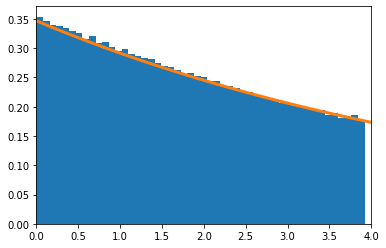

In [41]:
#Plot the SSA cell age distribution
cell_age=phase*Tcycle/Ncycle
Bins=Ncycle
plt.hist(cell_age,bins=Bins,density=True)

#Plot the theoretical cell age distribution f(t)=2^(1-t/T)*Log[2]/T,t=x*T/N,x is the cell phase
t=np.linspace(0,np.max(Tcycle),10000)
ft=[2**(1-i/Tcycle)*np.log(2)/Tcycle for i in t]
plt.plot(t, ft,linewidth=3)
plt.xlim(0,Tcycle)
plt.show()
plt.savefig("params3.pdf")

In [33]:
#save data
data_save=pd.DataFrame(data[:,1:])
data_save.to_csv("cell1son0.1sof2rho2lam6dm1T4N50tmax80.csv")